## PyTorch Autograd functions

In [1]:
import torch

In [2]:
torch.set_default_dtype(torch.float32)
torch.get_default_dtype()

torch.float32

In [3]:
tensor1 = torch.tensor([[1, 2, 3],
                         [4, 5, 6]], dtype=torch.float32)
tensor1

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [4]:
tensor2 = torch.tensor([[10, 20, 30],
                        [40, 50, 60]], dtype=torch.float32)
tensor2

tensor([[10., 20., 30.],
        [40., 50., 60.]])

In [5]:
tensor1.requires_grad

False

In [6]:
tensor2.requires_grad

False

By default, every PyTorch Tensor has a requires_grad property. When True, Pytorch tracks tensor computations in the forward pass and calculates gradients in the backward pass.  

If not set to True, to enable tracking history that allows calculation of gradients with respect to the Tensor, _call_ the `requires_grad_()` function which sets the value to True. 

In [7]:
tensor1.requires_grad_() # Updates the requires grad property IN-Place

tensor([[1., 2., 3.],
        [4., 5., 6.]], requires_grad=True)

In [8]:
tensor1.requires_grad # check

True

In [9]:
tensor2.requires_grad # still False

False

Tensors and functions make up our **DAG**, *directed acyclic computation graph*

In [10]:
print(tensor1.grad) # no gradients have been calculated

None


In [11]:
print(tensor1.grad_fn) # the computational tree is empty

None


Tensors are the nodes in this graph and the functions are the transformations along the edges. Together tensors & functions make up the Directed Acyclic Computation Graph


Every tensor has a grad function to create that function.

Let's set up our first Simple computation graph.

In [12]:
output_tensor = tensor1 * tensor2
output_tensor

tensor([[ 10.,  40.,  90.],
        [160., 250., 360.]], grad_fn=<MulBackward0>)

The `requires_grad` property is based on the input tensors used to create it. `tensor1` requires_grad property was set to `True`

In [13]:
output_tensor.requires_grad 

True

The `grad` property of the `output_tensor` is `None` because there are no gradients created from a backward pass. 

In [14]:
print(output_tensor.grad) 

None


<ipython-input-14-2e7da3899fae>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  print(output_tensor.grad)


In [15]:
print(output_tensor.grad_fn) # multiplication based tensor

In [16]:
print(tensor1.grad_fn)
print(tensor2.grad_fn)

None
None


Different operation: 

In [17]:
output_tensor = (tensor1 * tensor2).mean()
print(output_tensor.grad_fn) # grad_fn references the last function

In [18]:
print(tensor1.grad) # only when backward function is called on an output

None


In [19]:
output_tensor.backward() # partial derivatives now calculated

In [20]:
print(tensor1.grad)

tensor([[ 1.6667,  3.3333,  5.0000],
        [ 6.6667,  8.3333, 10.0000]])


Gradients are partial derivatives wrt every value of tensor1, the shapes are the same

In [21]:
tensor1.grad.shape, tensor1.shape

(torch.Size([2, 3]), torch.Size([2, 3]))

In [22]:
print(tensor2.grad) # none calculated, required_grad was False

None


In [23]:
print(output_tensor.grad) # this is the value wrt the partial derivatives are calculated so it doesn't have gradients

None


<ipython-input-23-95e125c76021>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  print(output_tensor.grad) # this is the value wrt the partial derivatives are calculated so it doesn't have gradients


requires_grad property is propagated from inp tensors to res tens

In [24]:
new_tensor = tensor1 * 3
print(new_tensor.requires_grad)

True


Grad func is mulbackward, mult op that created this tensor
if tracking history is enabled:

In [25]:
with torch.no_grad(): # to stop autograd to stop computations with tracking hist off
    new_tensor = tensor1 * 3
    print('new tensor = ', new_tensor)
    print('requires_grad for tensor = ', tensor1.requires_grad)
    print('requires_grad for tensor1 = ', tensor2.requires_grad)
    print('requires_grad for new_tensor = ', new_tensor.requires_grad)
    

new tensor =  tensor([[ 3.,  6.,  9.],
        [12., 15., 18.]])
requires_grad for tensor =  True
requires_grad for tensor1 =  False
requires_grad for new_tensor =  False


The original tensor1 has requires_grad = True and the new_tensor has it set to False, no propagation becase requires_grad was set to False.

In [26]:
def calculate(t):
    return t * 2

In [27]:
@torch.no_grad()
def calculate_with_no_grad(t):
    return t * 2

In [28]:
result_tensor = calculate(tensor1)
result_tensor # grad function is MulBackward0 because it was created using a multiplication operation

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.]], grad_fn=<MulBackward0>)

In [29]:
result_tensor.requires_grad

True

In [30]:
# Calc teh result tensor but with no_grad decorator
# @torch.no_grad()
result_tensor_no_grad = calculate_with_no_grad(tensor1)
result_tensor_no_grad # does not keep track

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.]])

In [31]:
result_tensor_no_grad.requires_grad

False

**Nesting Inner blocks where you want history tracking and gradients to be calculated within an outer no_grad block**: We can enable history tracking of gradients within a no_grad block: In general we want to turn it off but we can turn it off for select computations within a `no_grad` block

In [32]:
with torch.no_grad():
    new_tensor_no_grad = tensor1 * 3
    print('new_tensor_no_grad = ', new_tensor_no_grad)
    
    with torch.enable_grad():
        new_tensor_grad = tensor1 * 3
        print('new_tensor_grad = ', new_tensor_grad)

new_tensor_no_grad =  tensor([[ 3.,  6.,  9.],
        [12., 15., 18.]])
new_tensor_grad =  tensor([[ 3.,  6.,  9.],
        [12., 15., 18.]], grad_fn=<MulBackward0>)


If ANY of the input tensors have their `requires_grad` property set to True, then the computed tensors will as well. 

In [33]:
tensor_one = torch.tensor([[1.0, 2.0],
                           [3.0, 4.0]], requires_grad=True)
tensor_one

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

Create another tensor, by default requires_grad will be set to False


In [34]:
tensor_two = torch.Tensor([[5, 6],
                           [7, 8]])
tensor_two

tensor([[5., 6.],
        [7., 8.]])

In [35]:
tensor_one.requires_grad, tensor_two.requires_grad

(True, False)

In [36]:
tensor_two.requires_grad_()

tensor([[5., 6.],
        [7., 8.]], requires_grad=True)

In [37]:
tensor_one.requires_grad, tensor_two.requires_grad

(True, True)

In [38]:
final_tensor = (tensor_one + tensor_two).mean()
final_tensor

tensor(9., grad_fn=<MeanBackward0>)

So far, we have only completed forward pass; there are no gradients associated with `tensor_one`, nor with `tensor_two`

In [39]:
final_tensor.backward()

In [40]:
print(tensor_one.grad)

tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])


In [41]:
print(tensor_two.grad)

tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])


Tensors involved in a computation are part of a larger computation graph. If you want to detach a tensor from the graph, you can call the detach function on tensor. **The detached tensor will always have its `requires_grad` property set to `False`**

In [42]:
detached_tensor = tensor_one.detach()
detached_tensor

tensor([[1., 2.],
        [3., 4.]])

In [43]:
# Let's use these in a computation
mean_tensor = (tensor_one + detached_tensor).mean()
mean_tensor.backward()

In [44]:
tensor_one.grad

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]])

In [45]:
mean_tensor.backward()

In [46]:
tensor_one.grad

tensor([[0.7500, 0.7500],
        [0.7500, 0.7500]])

In [47]:
detached_tensor.grad # none calculated

### Variable API

** The Variable API in PyTorch has been deprecated**: Variables are no longer needed to work with autograd and to store gradients. 

Variables were tailored to hold values during training. The gradient vector, grad fnction etc are now part of the Tensor function itself. 

You can still use it:

In [48]:
import torch
from torch.autograd import Variable

In [49]:
var = Variable(torch.FloatTensor([9]))
var, var.requires_grad

(tensor([9.]), False)

In [50]:
var.requires_grad_()

tensor([9.], requires_grad=True)

In [51]:
w1 = Variable(torch.FloatTensor([3]), requires_grad=True)
w2 = Variable(torch.FloatTensor([10]), requires_grad=True)
print(w1)
print(w2)

tensor([3.], requires_grad=True)
tensor([10.], requires_grad=True)


In [52]:
result_var = var * w1
result_var # this is also a `tensor`

tensor([27.], grad_fn=<MulBackward0>)

In [53]:
result_var.requires_grad

True

The `backward()` function call will work exactly the same way: it calculates the gradients for all of the input tensors where `requires_grad` property was set to `True`

In [54]:
result_var.backward()

* `w1.grad` contains the gradients for `w1` with respect to `result_var`
* `w2` was not involved in the operation so it will not contain any gradients
* and `var` will contain gradients as well

In [55]:
(w1.grad, w2.grad, var.grad)

(tensor([9.]), None, tensor([3.]))

In [56]:
w2.grad

# Building a linear model with Autograd

**See**
[04e_demo7-LinearModelUsingAutograd_ys_notes](04e_demo7-LinearModelUsingAutograd_ys_notes.ipynb)

# Dynamic Computation

**See**
[04f_dynamic_computation](04f_dynamic_computation.ipynb)

## Backpropagation 

Building graphs dyanamically using PyTorch

In [57]:
from graphviz import Digraph
from graphviz import Source
from IPython.display import Image

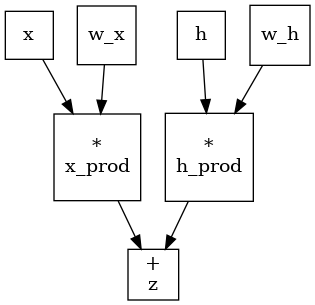

In [58]:
temp = """
digraph G{
edge [dir=forward]
node [shape=square]
x [label="x"]
w_x [label="w_x"]
x -> x_prod
x_prod [label="*\nx_prod"]
w_x -> x_prod

h [label="h"]
w_h [label="w_h"]
h -> h_prod
w_h -> h_prod
h_prod [label="*\nh_prod"]
x_prod -> z
h_prod -> z
z [label="+\nz"]
}
"""
s = Source(temp, filename="nn3.gv", format="png")
Image('nn3.gv.png')

In [59]:
x = torch.rand(1, 10, requires_grad=True)
prev_h = torch.rand(1, 20)
W_h = torch.rand(20, 20)
W_x = torch.rand(20, 10)

i2h = torch.mm(W_x, x.t())
h2h = torch.mm(W_h, prev_h.t())
next_h = i2h + h2h
next_h = next_h.tanh()

In [60]:
x.requires_grad

True

In [61]:
next_h.requires_grad

True